<a href="https://colab.research.google.com/github/Magui2912/Project_2_coding_dojo/blob/main/Majdijedoui__Belt_Exam_B_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import sklearn.externals as extjoblib
import numpy as np
import joblib as extjoblib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks

In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.0 MB/s eta 0:00:00


In [3]:
# Import and init shap
import shap
shap.initjs()

***Part 1***

In [5]:
!pip install --upgrade pandas joblib


In [4]:
import joblib
import pandas as pd
loaded = joblib.load('/content/drive/MyDrive/Data Viz Belt Exam - OptionB.zip (Unzipped Files)/saved_model.joblib')

In [5]:
# Display the .keys of the dictionary stored in the joblib file.
loaded.keys()

dict_keys(['preprocessor', 'X_train', 'X_test', 'y_train', 'y_test', 'LinearRegression', 'RandomForestRegressor'])

In [9]:
loaded

{'preprocessor': ColumnTransformer(transformers=[('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x787c69b56950>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(fill_value='MISSING',
                                                                 strategy='constant')),
                                                  ('onehotencoder',
                                                   OneHotEncoder(drop='if_binary',
                                                                 sparse=False))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x787c69b56b90>)],
                   verbose_feat

In [6]:
# Assign each of the keys from the dictionary as a separate variable.

X_train = loaded['X_train']
y_train = loaded['y_train']
X_test = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
LR_model = loaded['LinearRegression']
RF_model = loaded['RandomForestRegressor']

In [7]:
# Use the preprocessor to transform the X_train/X_test data into processed dataframes.

feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)  # Replace the column names with the correct feature names extracted from the preprocessor.

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)

X_train_df  # Just to display the created dataframe

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Street_Pave
853,16269.0,69.230685,5.0,907.0,907.0,5.0,1.0,1.0
1055,13891.0,107.000000,5.0,1710.0,1710.0,6.0,1.0,1.0
2483,8900.0,69.230685,4.0,1056.0,1056.0,5.0,1.0,1.0
2351,11475.0,85.000000,6.0,713.0,1552.0,6.0,1.0,1.0
1700,13654.0,118.000000,5.0,1704.0,2758.0,9.0,1.0,1.0
...,...,...,...,...,...,...,...,...
1425,11778.0,91.000000,5.0,2271.0,2276.0,7.0,1.0,1.0
1833,10678.0,85.000000,5.0,1683.0,2872.0,9.0,1.0,1.0
2847,10890.0,60.000000,5.0,1058.0,1551.0,6.0,1.0,1.0
124,8800.0,80.000000,7.0,936.0,1054.0,6.0,1.0,1.0


Explain the Linear Regression Model

In [8]:
# Extract the coefficients and save them as a Series with the correct feature names as the index.

def get_coeffs_linreg(linreg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = linreg.feature_names_in_

    ## Saving the coefficients
    coeffs = pd.Series(linreg.coef_, index= feature_names)
    coeffs['intercept'] = linreg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [10]:
coeffs = get_coeffs_linreg(LR_model)
coeffs

Street_Pave     -30492.124266
TotRms AbvGrd    -7389.740031
intercept            0.000000
Lot Area             0.110429
Overall Cond        14.161296
Total Bsmt SF       60.738960
Lot Frontage        87.966327
Gr Liv Area        103.864442
Central Air_Y    34200.410448
dtype: float64

In [11]:
# Change the pandas option for float format to display the coefficients with pandas in a readable form:


pd.set_option('display.float_format',lambda x: f"{x:,.2f}")
coeffs

Street_Pave     -30,492.12
TotRms AbvGrd    -7,389.74
intercept             0.00
Lot Area              0.11
Overall Cond         14.16
Total Bsmt SF        60.74
Lot Frontage         87.97
Gr Liv Area         103.86
Central Air_Y    34,200.41
dtype: float64

In [12]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')

    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"

    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
           ylabel='Feature Names',
           title=title)
    ax.axvline(0, color='k')

    ## return ax in case want to continue to update/modify figure
    return ax

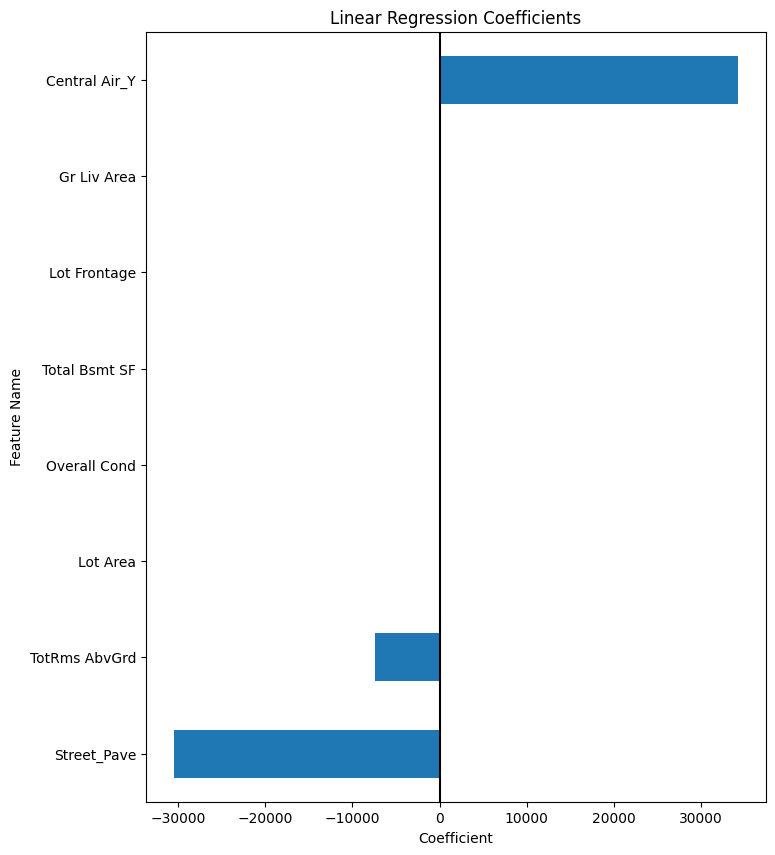

In [13]:
## Create a bar graph of the coefficients, sorted from largest to smallest.

ax = plot_coeffs(coeffs, figsize=(8,10))
ax.set(title='Linear Regression Coefficients', ylabel='Feature Name', xlabel='Coefficient')
fig_2 = ax.get_figure()

# The provided coefficients are from a linear regression model, where each coefficient represents the change in the target variable (presumably the price of a property) for a one-unit increase in the corresponding feature, holding all other features constant. Here's the interpretation for the three largest positive coefficients:#

**1.Central Air_Y (31,927.22):** Having central air conditioning increases the price of a property by approximately $31,927.22. This suggests that properties with central air conditioning tend to command a higher price compared to those without it.



**2.Overall Cond (1,737.31):** An increase of one unit in the overall condition rating of a property increases its price by approximately $1,737.31. This implies that properties with better overall conditions generally have higher prices.



**3.Land Contour_HLS (4,243.63):** Properties with a 'Hillside' land contour have a higher price by approximately $4,243.63 compared to properties with other land contours. This suggests that the presence of a hillside contour positively impacts the property's price.

## **To interpret the impact of the three largest negative coefficients on the target variable:**



**1.Land Contour_Bnk:** The coefficient of -72,620.47 suggests that for each unit increase in the presence of a banked land contour, the target variable (presumably property price or some related measure) decreases by approximately $72,620.47. This implies that properties located on a banked land contour tend to have lower prices compared to properties on other types of land contours.

**2.Land Contour_Low:** With a coefficient of -43,310.96, it indicates that for each unit increase in the presence of a low land contour, the target variable decreases by approximately $43,310.96. This suggests that properties situated on low land contours tend to have lower prices compared to properties on other types of land contours.

**3.Land Contour_Lvl:** The coefficient of -42,264.19 suggests that for each unit increase in the presence of a level land contour, the target variable decreases by approximately $42,264.19. This implies that properties located on level land contours tend to have lower prices compared to properties on other types of land contours.



##In summary, properties situated on banked, low, or level land contours tend to have lower prices compared to properties on other types of land contours, based on the given coefficients.

## **Explain the Random Forest Model**

In [14]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):

    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [15]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

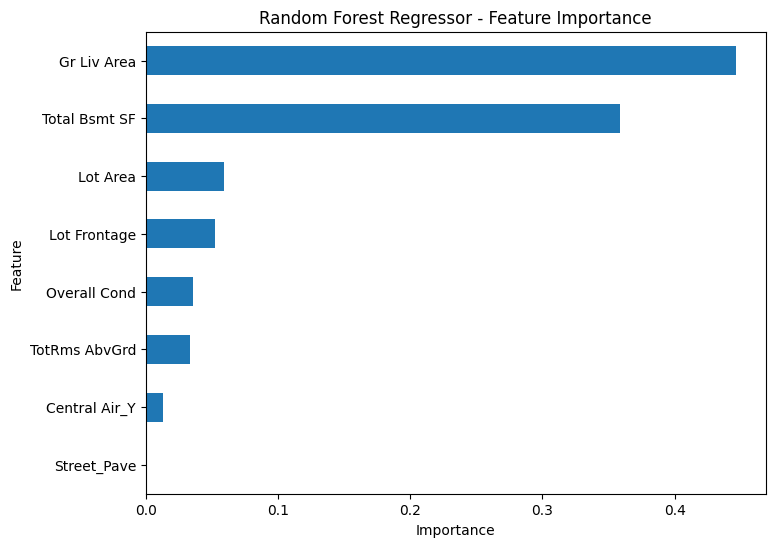

In [16]:
# Extract and create a bar graph of the feature importances, sorted from largest to smallest.

importance = get_importances(RF_model, sort=True, ascending=True)
ax = importance.plot(kind='barh',figsize=(8,6))
ax.set(title='Random Forest Regressor - Feature Importance', ylabel='Feature', xlabel='Importance');
fig_2 = ax.get_figure()

## **What are the top 6 most important features?**

### The top 6 most important features are:
   - Gr Liv Area
   - Total Bsmt 5F
   - Lot Area
   - Lot Frontage
   - Overal Cond
   - TotRms AbvGrd

### **Of the top 6 most important features, identify which of these features also appeared in the 3 largest or 3 smallest coefficients.**

   - Only "Overal Cond" appear in the 3 largest coefficients of the linear regression model.

## **Apply Shap to Explain the Random Forest Model**

In [17]:
X_shap = shap.sample(X_train_df, nsamples = 500,random_state=321)
X_shap

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Street_Pave
2605,"10,800.00",60.00,8.00,796.00,"1,466.00",7.00,1.00,1.00
2520,"3,874.00",40.00,5.00,"1,226.00","1,226.00",4.00,1.00,1.00
1251,"8,838.00",71.00,3.00,0.00,"1,764.00",7.00,1.00,1.00
2478,"7,153.00",65.00,5.00,761.00,"1,603.00",7.00,1.00,1.00
2108,"11,750.00",75.00,5.00,"1,546.00","1,546.00",7.00,1.00,1.00
...,...,...,...,...,...,...,...,...
1291,"11,426.00",63.00,6.00,828.00,"1,594.00",9.00,1.00,1.00
2205,"7,128.00",53.00,5.00,918.00,"1,646.00",7.00,1.00,1.00
797,"9,060.00",60.00,5.00,560.00,"1,258.00",6.00,1.00,1.00
2103,"9,588.00",69.00,5.00,"1,482.00","2,574.00",10.00,1.00,1.00


In [18]:
# Save the corresponding y_train values as y_shap

y_shap = y_train.loc[X_shap.index]

# y_shap = y_train.reindex(X_shap.index) ==> AI proposed by gave me 40 NaN values
y_shap

2605    170000
2520    190000
1251    100000
2478    175900
2108    217000
         ...  
1291    118000
2205    164000
797     105000
2103    276000
1006    194500
Name: SalePrice, Length: 500, dtype: int64

In [19]:
# Create a shap model explainer for the random forest model

explainer = shap.Explainer(RF_model)

In [20]:
# Calculate the shap values for the sampled data

shap_values = explainer(X_shap,y_shap)

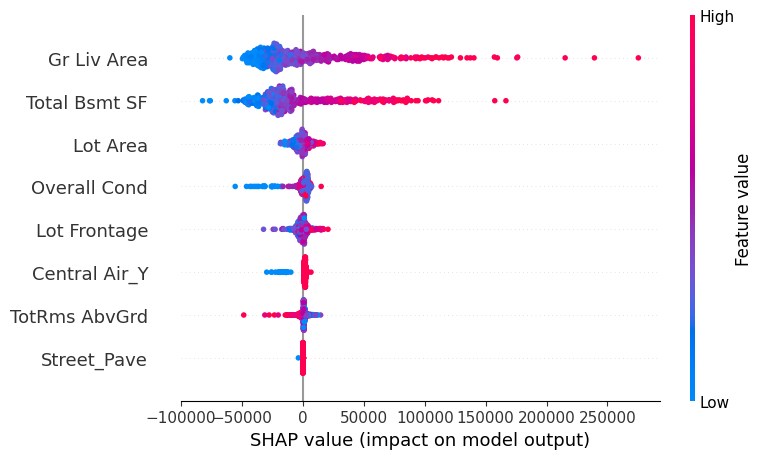

In [21]:
# Create a summary plot (plot_type =’dot’) of the most important features, according to shap.

shap.summary_plot(shap_values, features = X_shap)

## **Interpret the top 6 most important features. According to shap, what effect does each feature have on the model’s prediction?**

### If we look at the feature (that are shown in the order of global feature importance with the first one being the most important and the last being the least important on model prediction):
   - **GrLivArea** (Above grade (ground) living area square feet), one can see that it is mostly high with a positive SHAP value. It means higher GrLivArea values tend to positivly affect our model output;
   - **TotalBsmtSF** (Total square feet of basement area), one can see that is also mostly high with a positive SHAP value. It means higher TotalBsmtSF values tend to positivly affect our model output;
   - **OverallCond** (Overall condition rating), one can see that it is mostly low with a negative SHAP value. It means higher GrLivArea values tend to negatively affect our model output;
   - Both **Lot Area** (Lot size in square feet) and **Lot Frontage** (Linear feet of street connected to property) have almost no contribution on the prediction, whether its values are high or low.
   - **Cenral Air_Y** (Central air conditioning _ Yes) has a negative contribution when its values are low (the bleu dotes on the left), and a low positive contrinution on high values.

## ***Part 2***

In [22]:
# Load the provided csv, located in the zip file you downloaded in Part 1.

df = pd.read_csv('/content/drive/MyDrive/Data Viz Belt Exam - OptionB.zip (Unzipped Files)/zillow_home_values-zipcode.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Columns: 284 entries, RegionID to 30112022
dtypes: float64(275), int64(3), object(6)
memory usage: 59.5+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,29022000,31032000,30042000,31052000,30062000,31072000,31082000,30092000,31102000,30112000,31122000,31012001,28022001,31032001,30042001,31052001,30062001,31072001,31082001,30092001,31102001,30112001,31122001,31012002,28022002,31032002,30042002,31052002,30062002,31072002,31082002,30092002,31102002,30112002,31122002,31012003,28022003,31032003,30042003,31052003,...,31102018,30112018,31122018,31012019,28022019,31032019,30042019,31052019,30062019,31072019,31082019,30092019,31102019,30112019,31122019,31012020,29022020,31032020,30042020,31052020,30062020,31072020,31082020,30092020,31102020,30112020,31122020,31012021,28022021,31032021,30042021,31052021,30062021,31072021,31082021,30092021,31102021,30112021,31122021,31012022,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,"107,261.00","107,274.00","107,076.00","107,081.00","107,112.00","107,325.00","107,480.00","107,709.00","108,092.00","108,328.00","108,782.00","109,187.00","109,242.00","109,045.00","108,514.00","108,330.00","108,390.00","108,548.00","108,693.00","108,464.00","108,504.00","108,660.00","108,944.00","109,056.00","109,176.00","109,353.00","109,930.00","110,527.00","111,058.00","111,451.00","111,944.00","112,638.00","113,249.00","113,778.00","114,116.00","114,439.00","114,716.00","114,936.00","115,268.00","115,595.00","116,009.00",...,"183,387.00","184,111.00","184,809.00","185,700.00","186,367.00","186,795.00","186,730.00","186,898.00","187,336.00","187,990.00","188,582.00","188,900.00","189,633.00","190,880.00","192,023.00","192,237.00","192,266.00","193,375.00","195,037.00","196,166.00","196,393.00","196,751.00","197,546.00","199,676.00","201,967.00","204,564.00","206,902.00","209,154.00","212,069.00","213,553.00","215,782.00","218,494.00","223,994.00","229,959.00","236,318.00","241,418.00","246,015.00","249,379.00","253,321.00","257,274.00","261,945.00","267,644.00","273,946.00","280,066.00","285,121.00","288,532.00","290,458.00","291,103.00","292,081.00","292,948.00"
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,"222,569.00","222,885.00","223,602.00","224,818.00","224,384.00","224,051.00","222,942.00","223,281.00","222,886.00","223,553.00","224,715.00","226,127.00","226,742.00","226,052.00","225,191.00","224,344.00","225,654.00","227,161.00","228,329.00","228,637.00","228,208.00","228,270.00","227,805.00","226,857.00","226,276.00","225,961.00","226,847.00","227,512.00","228,610.00","229,355.00","229,220.00","228,621.00","227,252.00","226,692.00","225,896.00","226,760.00","228,102.00","229,657.00","230,436.00","230,730.00","230,932.00",...,"335,794.00","336,715.00","336,468.00","336,749.00","336,288.00","336,146.00","335,148.00","334,467.00","333,912.00","334,156.00","334,272.00","335,057.00","335,460.00","335,794.00","335,513.00","335,147.00","334,758.00","335,048.00","335,908.00","336,855.00","337,292.00","337,429.00","338,718.00","340,293.00","342,915.00","346,146.00","350,598.00","354,599.00","359,133.00","364,502.00","370,992.00","377,896.00","386,576.00","397,227.00","408,018.00","417,061.00","424,951.00","431,973.00","437,659.00","443,701.00","453,150.00","464,727.00","478,369.00","489,712.00","497,173.00","499,429.00","497,572.00","498,113.00","500,187.00","503,109.00"
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,"90,009.00","90,009.00","90,042.00","90,007.00","90,027.00","89,987.00","89,972.00","89,926.00","89,397.00","88,767.00","87,904.00","87,765.00","87,719.00","87,845.00","87,409.00","87,119.00","86,687.00","86,521.00","86,289.00","86,068.00","85,909.00","85,645.00","85,499.00","85,113.00","84,858.00","84,710.00","84,940.00","85,102.00","85,365.00","85,547.00","85,936.00","86,165.00","86,468.00","86,751.00","86,989.00","87,324.00","87,443.00","87,661.00","87,664.00","87,732.00","87,812.00",

In [23]:
id_vars = df.columns[:9]
id_vars

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName'],
      dtype='object')

In [24]:
# Prepare the data as a time series DataFrame:

## Melt the wide-form data into a long-form time series
### The date column should be named “Date”
### The value column should be named “Confirmed”

df_melted = pd.melt(df, var_name="Date", id_vars=id_vars, value_name = 'Home Value')
df_melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,"107,261.00"
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,"222,569.00"
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,"90,009.00"
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"188,096.00"
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"275,983.00"
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,"193,591.00"
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,"376,523.00"
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,"110,082.00"
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,"75,810.00"


In [25]:
df_melted['Date'] = pd.to_datetime(df_melted['Date'], format='%d%m%Y')
df_melted.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,"107,261.00"
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2000-01-31,"222,569.00"
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,2000-01-31,"90,009.00"
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,"188,096.00"
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,"275,983.00"


In [26]:
# Set the Date column as the index

df_melted = df_melted.set_index('Date')
df_melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,"107,261.00"
2000-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,"222,569.00"
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,"90,009.00"
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"188,096.00"
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"275,983.00"
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,"193,591.00"
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,"376,523.00"
2022-11-30,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,"110,082.00"


In [31]:
# prompt: Avec le DataFrame df_melted: df_F = df_melted[df_melted['State'].isin(['CA', "WA", "OR", 'AZ', 'NV']) & (df_melted.index.year >= 2010) & (df_melted.index.year <= 2020)] df_F

df_F = df_melted.loc[(df_melted['State'].isin(['MA', "PA", "NY", 'NJ', 'MD'])) & (df_melted.index.year >= 2008) & (df_melted.index.year <= 2018)]


In [33]:
#write dataframe to file
df_F.to_csv("/content/drive/MyDrive/Data Viz Belt Exam - OptionB.zip (Unzipped Files)/dat-for-tableau.csv", sep=';')
#read it back
pd.read_csv("/content/drive/MyDrive/Data Viz Belt Exam - OptionB.zip (Unzipped Files)/dat-for-tableau.csv", sep=';').head()

,Date,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
0,2008-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"447,718.00"
1,2008-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"538,860.00"
2,2008-01-31,61148,10,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,"358,246.00"
3,2008-01-31,62046,11,11236,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,"468,185.00"
4,2008-01-31,62019,14,11208,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,"486,673.00"


In [40]:
df_F['Metro'].value_counts()

New York-Newark-Jersey City, NY-NJ-PA          112200
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD     41976
Pittsburgh, PA                                  39468
Boston-Cambridge-Newton, MA-NH                  29568
Baltimore-Columbia-Towson, MD                   19272
                                                ...  
Selinsgrove, PA                                   924
Lewisburg, PA                                     924
St. Marys, PA                                     792
Seneca Falls, NY                                  792
Vineyard Haven, MA                                792
Name: Metro, Length: 82, dtype: int64

In [34]:
# Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.

df_G = df_F.groupby('State').resample('YS').mean()
df_G

<ipython-input-34-5b729b5c9633>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_G = df_F.groupby('State').resample('YS').mean()


RegionID  SizeRank  RegionName  Home Value
State Date                                                  
MA    2008-01-01 58,542.19 11,144.98    1,874.83  370,276.13
      2009-01-01 58,542.19 11,144.98    1,874.83  353,451.30
      2010-01-01 58,542.19 11,144.98    1,874.83  354,704.04
      2011-01-01 58,542.19 11,144.98    1,874.83  344,022.05
      2012-01-01 58,542.19 11,144.98    1,874.83  337,760.41
      2013-01-01 58,542.19 11,144.98    1,874.83  358,073.75
      2014-01-01 58,542.19 11,144.98    1,874.83  378,459.69
      2015-01-01 58,542.19 11,144.98    1,874.83  393,671.95
      2016-01-01 58,542.19 11,144.98    1,874.83  407,772.94
      2017-01-01 58,542.19 11,144.98    1,874.83  427,188.85
      2018-01-01 58,542.19 11,144.98    1,874.83  450,979.54
MD    2008-01-01 66,810.87 13,259.26   21,245.92  359,630.33
      2009-01-01 66,810.87 13,259.26   21,245.92  319,528.86
      2010-01-01 66,810.87 13,259.26   21,245.92  305,117.95
      2011-01-01 66,810.87 13,259.26   21,245.92  291,514.46
      2012-01-01 66,810.87 13,259.26   21,245.92  284,355.91
      2013-01-01 66,810.87 13,259.26   21,245.92  296,858.04
      2014-01-01 66,810.87 13,259.26   21,245.92  306,695.24
      2015-01-01 66,810.87 13,259.26   21,245.92  306,827.05
      2016-01-01 66,810.87 13,259.26   21,245.92  308,879.07
      2017-01-01 66,810.87 13,259.26   21,245.92  317,503.22
      2018-01-01 66,810.87 13,259.26   21,245.92  327,619.58
NJ    2008-01-01 60,875.61 10,151.58    7,925.83  419,298.05
      2009-01-01 60,875.61 10,151.58    7,925.83  392,674.67
      2010-01-01 60,875.61 10,151.58    7,925.83  379,620.17
      2011-01-01 60,875.61 10,151.58    7,925.83  358,189.41
      2012-01-01 60,875.61 10,151.58    7,925.83  341,947.98
      2013-01-01 60,875.61 10,151.58    7,925.83  346,531.07
      2014-01-01 60,875.61 10,151.58    7,925.83  361,237.88
      2015-01-01 60,875.61 10,151.58    7,925.83  362,191.10
      2016-01-01 60,875.61 10,151.58    7,925.83  364,417.33
      2017-01-01 60,875.61 10,151.58    7,925.83  373,991.76
      2018-01-01 60,875.61 10,151.58    7,925.83  388,572.46
NY    2008-01-01 63,176.34 14,641.25   12,724.88  295,154.78
      2009-01-01 63,176.34 14,641.25   12,724.88  278,740.46
      2010-01-01 63,176.34 14,641.25   12,724.88  271,226.92
      2011-01-01 63,176.34 14,641.25   12,724.88  267,413.73
      2012-01-01 63,176.34 14,641.25   12,724.88  263,891.64
      2013-01-01 63,176.34 14,641.25   12,724.88  270,369.31
      2014-01-01 63,176.34 14,641.25   12,724.88  284,347.55
      2015-01-01 63,176.34 14,641.25   12,724.88  296,118.28
      2016-01-01 63,176.34 14,641.25   12,724.88  303,402.83
      2017-01-01 63,176.34 14,641.25   12,724.88  313,697.02
      2018-01-01 63,176.34 14,641.25   12,724.88  327,252.61
PA    2008-01-01 66,345.55 15,209.64   17,182.52  196,780.89
      2009-01-01 66,345.55 15,209.64   17,182.52  175,373.03
      2010-01-01 66,345.55 15,209.64   17,182.52  170,814.76
      2011-01-01 66,345.55 15,209.64   17,182.52  162,272.05
      2012-01-01 66,345.55 15,209.64   17,182.52  157,486.61
      2013-01-01 66,345.55 15,209.64   17,182.52  158,731.09
      2014-01-01 66,345.55 15,209.64   17,182.52  161,301.36
      2015-01-01 66,345.55 15,209.64   17,182.52  162,618.03
      2016-01-01 66,345.55 15,209.64   17,182.52  163,920.96
      2017-01-01 66,345.55 15,209.64   17,182.52  167,865.80
      2018-01-01 66,345.55 15,209.64   17,182.52  175,347.29

In [35]:
df_G = df_G.drop(columns = ['RegionID', 'SizeRank', 'RegionName'])
df_G.head()

Home Value
State Date                  
MA    2008-01-01  370,276.13
      2009-01-01  353,451.30
      2010-01-01  354,704.04
      2011-01-01  344,022.05
      2012-01-01  337,760.41

In [36]:
df_unstacked = df_G.unstack(level=0)
df_unstacked.head()

Home Value                                            
State              MA         MD         NJ         NY         PA
Date                                                             
2008-01-01 370,276.13 359,630.33 419,298.05 295,154.78 196,780.89
2009-01-01 353,451.30 319,528.86 392,674.67 278,740.46 175,373.03
2010-01-01 354,704.04 305,117.95 379,620.17 271,226.92 170,814.76
2011-01-01 344,022.05 291,514.46 358,189.41 267,413.73 162,272.05
2012-01-01 337,760.41 284,355.91 341,947.98 263,891.64 157,486.61

In [37]:
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in thousands"""
    return f"{x/1_000:,.0f}K"

fmt_thous = mticks.FuncFormatter(thousands)

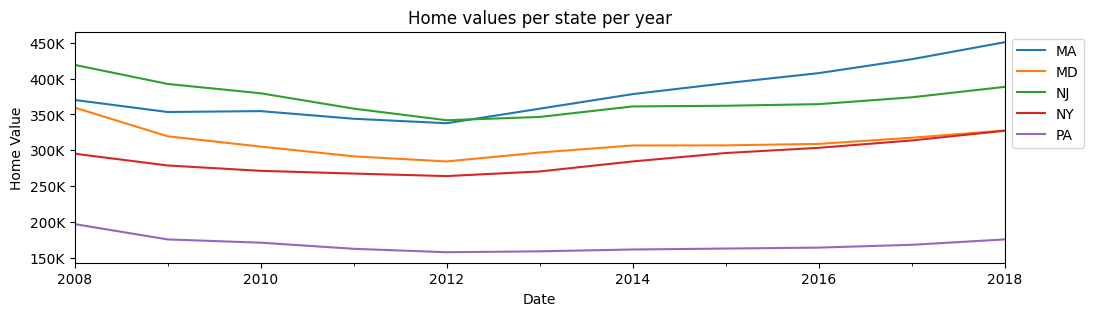

In [38]:
# Plot a line graph with each of the states as a separate line.

fig, ax = plt.subplots(figsize=(12,3))
df_unstacked['Home Value'].plot(ax=ax, title= 'Home values per state per year', ylabel= 'Home Value')
## Set the y-axes major formatters
ax.yaxis.set_major_formatter(fmt_thous)
ax.legend(bbox_to_anchor=[1,1])

# **Part 3**

[Tableau Workbook](https://public.tableau.com/views/Tableauworkbook_17131001938730/Feuille5?:language=en-US&publish=yes&:sid=&:display_count=n&:origin=viz_share_link)